<a href="https://colab.research.google.com/github/abhistar/DDP_GAN/blob/main/materialGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from PIL import Image
from torch.autograd import Variable
import time
import warnings
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
manual_seed = int(time.time())
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# location of folder
dataroot = "drive/MyDrive/SuperFolderTrainData"
# number of workers
workers = 2
# batch size for training
batch_size = 30
# image size for input
image_size = 128
# number of channel (1 for BW, 3 for RGB)
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 16
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128
# Number of training epochs
num_epochs = 50
# Learning rate for optimizers
lr = 0.0005
# Style loss weight
sl_loss_weight = 0.03
# Colapse loss weight
cl_loss_weight = 0.03
# Beta values hyperparam for Adam optimizers
beta1 = 0.5
beta2 = 0.99
# Number of GPUs available, currently running on CPU
ngpu = 1
 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Random Seed:  1623693526
Tesla P4


In [ ]:
# define weights for layer and normalisation
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# setup dataset and data loader
dataset = dset.ImageFolder(root=dataroot, transform=transforms.Compose([transforms.Resize(image_size), 
                                                                        transforms.CenterCrop(image_size),
                                                                        transforms.ToTensor(),
                                                                        transforms.Normalize((0.5,),(0.5,))]))
 
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
 
device = torch.device("cuda:0" if(torch.cuda.is_available() and ngpu>0) else "cpu")

In [ ]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential()
    
    # input z into convolution
    self.main.add_module('conv1', nn.ConvTranspose2d(nz, ngf*8, 8, 2, 0, bias=False))
    self.main.add_module('btch1', nn.BatchNorm2d(ngf*8))
    self.main.add_module('relu1', nn.ReLU(True))

    # state ngf * 8 * 8
    self.main.add_module('conv2', nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False))
    self.main.add_module('btch2', nn.BatchNorm2d(ngf*4))
    self.main.add_module('relu2', nn.ReLU(True))
            
    # state ngf/2 * 16*16
    self.main.add_module('conv3', nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False))
    self.main.add_module('btch3', nn.BatchNorm2d(ngf*2))
    self.main.add_module('relu3', nn.ReLU(True))
            
    # state ngf/4 * 32*32
    self.main.add_module('conv4', nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False))
    self.main.add_module('btch4', nn.BatchNorm2d(ngf))
    self.main.add_module('relu4', nn.ReLU(True))
            
    # state ngf/8 *64*64
    self.main.add_module('conv5', nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False))
    self.main.add_module('output', nn.Tanh())
        
    #state 1 *128*128
        
  def forward(self, input):
    return self.main(input)


# Create the generator
netG = Generator(ngpu).to(device)
 
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))
 
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)
 
# Print the model
print(netG)

# Access a particular layer
#print(netG.main.conv1)

# Get tensor of the layer
#print(netG.main.conv1.weight)

Generator(
  (main): Sequential(
    (conv1): ConvTranspose2d(16, 1024, kernel_size=(8, 8), stride=(2, 2), bias=False)
    (btch1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace=True)
    (conv5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential()

    # input is (nc) *128*128
    self.main.add_module('conv1', nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
    self.main.add_module('btch1', nn.BatchNorm2d(ndf))
    self.main.add_module('relu1', nn.LeakyReLU(0.2, inplace=True))

    # input is ndf/8 *64*64
    self.main.add_module('conv2', nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False))
    self.main.add_module('btch2', nn.BatchNorm2d(ndf*2))
    self.main.add_module('relu2', nn.LeakyReLU(0.2, inplace=True))

    #input is ndf/4 *32*32
    self.main.add_module('conv3', nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False))
    self.main.add_module('btch3', nn.BatchNorm2d(ndf*4))
    self.main.add_module('relu3', nn.LeakyReLU(0.2, inplace=True))

    #input is ndf/2 *16*16
    self.main.add_module('conv4', nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False))
    self.main.add_module('btch4', nn.BatchNorm2d(ndf*8))
    self.main.add_module('relu4', nn.LeakyReLU(0.2, inplace=True))

    #input is ndf *8*8
    self.main.add_module('conv5', nn.Conv2d(ndf*8, 1, 8, 1, 0, bias=False))
    self.main.add_module('output', nn.Sigmoid())

  def forward(self, input):
    return self.main(input), self.main.conv5

# Create the Discriminator
netD = Discriminator(ngpu).to(device)
 
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))
 
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
 
# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): LeakyReLU(negative_slope=0.2, i

In [ ]:
def gram_matrix(input):
  a, b, c, d = input.size() # a=batch size(=1) b=number of feature maps (c,d)=dimensions of a f. map (N=c*d)
  features = input.view(a * b, c * d) # resise F_XL into \hat F_XL
  G = torch.mm(features, features.t()) # compute the gram product
  return G.div(a * b * c * d) # we 'normalize' the values of the gram matrix by dividing by the number of element in each feature maps.

def style_loss(style_layer, combination_layer, num_channels = nc):
  assert style_layer.size()==combination_layer.size(), "Input Sizes do not match in StyleLoss"
  a, b, c, d = style_layer.size() # a=batch size(=1) b=number of feature maps (c,d)=dimensions of a f. map (N=c*d)
  styleloss = 0
  
  for i in range(a):
    S = gram_matrix(torch.unsqueeze(style_layer[i], 0)).detach()
    C = gram_matrix(torch.unsqueeze(combination_layer[i],0)).detach()
    styleloss = torch.add(styleloss, torch.sum(torch.square(S-C)/(2*num_channels*c*d)**2)*3e8)
    styleloss = Variable(styleloss, requires_grad=True)

  return styleloss

def colapse_loss(target_feature):
  z_d_gen = torch.flatten(target_feature).reshape(1,-1)
  nom = torch.mm(z_d_gen, z_d_gen.t())
  denom = torch.sqrt(torch.sum(torch.square(z_d_gen), 1, keepdim=True))
  pt = torch.square(torch.transpose((nom / denom), 1, 0))
  #pt = pt - torch.diag(torch.diag(pt))
  pulling_term = torch.sum(pt) / (batch_size * (batch_size - 1)*4e1)
  pulling_term = Variable(pulling_term, requires_grad=True)

  return pulling_term

vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

def get_vgg_layers(input, model=vgg19, num_layer=4):
  i = 0
  Model = copy.deepcopy(model)
  list_layers = nn.ModuleList()
  module = None
  for layer in Model.children():
    if isinstance(layer, nn.Conv2d):
      i +=1
      name = 'conv{}'.format(i)
      list_layers.append(module)
      module = nn.Sequential()
    elif isinstance(layer, nn.ReLU):
      name = 'relu{}'.format(i)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'btnm{}'.format(i)
    else: 
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    module.add_module(name, layer)

    if i >= (num_layer+1):
      break

  outconv1 = list_layers[1](input)
  outconv2 = list_layers[2](outconv1)
  outconv3 = list_layers[3](outconv2)
  outconv4 = list_layers[4](outconv3)

  return outconv1, outconv2, outconv3, outconv4

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


SConv1 shape: torch.Size([1, 64, 128, 128])
SConv2 shape: torch.Size([1, 64, 64, 64])
SConv3 shape: torch.Size([1, 128, 64, 64])
SConv4 shape: torch.Size([1, 128, 32, 32])


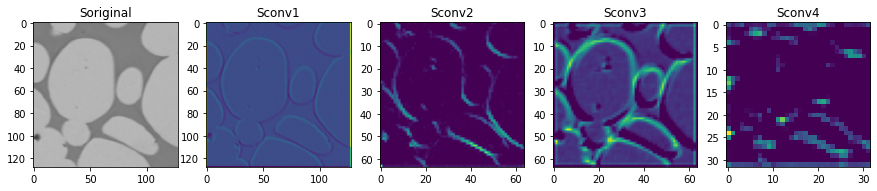

In [ ]:
# Visualise images and feature maps applied over them
loader = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size),
                             transforms.ToTensor()])
 
#Style Image
StyleImage = "drive/My Drive/SuperFolderTrainData/TrainData/5399.jpg"
style_image = Image.open(StyleImage)
style_image = loader(style_image)[:3,:,:].unsqueeze(0)

Sconv1, Sconv2, Sconv3, Sconv4 = get_vgg_layers(style_image.to(device, torch.float))
print('SConv1 shape: {}'.format(Sconv1.shape))
print('SConv2 shape: {}'.format(Sconv2.shape))
print('SConv3 shape: {}'.format(Sconv3.shape))
print('SConv4 shape: {}'.format(Sconv4.shape))

visuals = [
    ('Soriginal', style_image),
    ('Sconv1', Sconv1),
    ('Sconv2', Sconv2),
    ('Sconv3', Sconv3),
    ('Sconv4', Sconv4)]

plt.figure(figsize=(15,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  if(i==0):
    plt.imshow(visuals[i][1].squeeze().permute(1,2,0))
  else:
    for j in range(visuals[i][1].squeeze().shape[0]):
      plt.imshow(visuals[i][1].squeeze().cpu().detach().numpy()[j])
  plt.title(visuals[i][0])

In [ ]:
def get_style_colapse_loss(style_batch, gen_batch):
  Sconv1, Sconv2, Sconv3, Sconv4 = get_vgg_layers(style_batch)
  Cconv1, Cconv2, Cconv3, Cconv4 = get_vgg_layers(gen_batch)

  #Sconv1.detach_()
  #Sconv2.detach_()
  #Sconv3.detach_()
  #Sconv4.detach_()
  #Cconv1.detach_()
  #Cconv2.detach_()
  #Cconv3.detach_()
  #Cconv4.detach_()

  # style loss
  s1 = style_loss(Sconv1, Cconv1)
  s2 = style_loss(Sconv2, Cconv2)
  s3 = style_loss(Sconv3, Cconv3)
  s4 = style_loss(Sconv4, Cconv4)
  sl_loss = torch.mean(s1+s2+s3+s4)
  
  Cconv = torch.cat((torch.flatten(Cconv1), torch.flatten(Cconv2), torch.flatten(Cconv3), torch.flatten(Cconv4)), 0)
  # colapse loss
  #c1 = colapse_loss(Cconv1)
  #c2 = colapse_loss(Cconv2)
  #c3 = colapse_loss(Cconv3)
  #c4 = colapse_loss(Cconv4)
  c = colapse_loss(Cconv)
  cl_loss = torch.mean(c) #############(c1+c2+c3+c4)

  return sl_loss, cl_loss

In [ ]:
# Initialize BCELoss function
Dcriterion = nn.BCELoss()
Gcriterion = nn.BCELoss()
 
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(128, nz, 1, 1, device=device)
 
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
 
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=0.3)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=0.3)

In [ ]:
# Training loop
img_list = [] #stores prgressive images produced by generator
G_losses = [] #stores progressive losses by generator
D_losses = [] #stores progressive losses by discriminator
G_steps = 1 #train generator in every G_step
D_steps = 3 #train discriminator in every D_step
iter = 0 #track iteration

print('Starting Training')
for epoch in tqdm(range(num_epochs)):
  for i, data in enumerate(dataloader):
    D_realx, D_fakex, D_fakex2 = 0.0, 0.0, 0.0
    errD, errD_real, errD_fake = None, None, None
    fake_x = None
    # Train discriminator
    if i%D_steps==0:
      ############# REAL DATA ###############
      netD.zero_grad() # Reset gradients
      real_x = data[0].to(device) # Load real data
      b_size = real_x.size(0) # Batch size, should be equal to 30 as set earlier
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # Set real labels
      output = netD(real_x)[0].view(-1) # Pass real data through discriminator, flatten to keep columns fixed, i.e, b_size

      errD_real = Dcriterion(output, label) # Calculate loss on real data
      errD_real.backward() #Compute gradients

      D_realx = output.mean().item() # Mean output by discriminator over real data

      ############# FAKE DATA ###############
      noise = torch.randn(b_size, nz, 1, 1, device=device) # Generate noise data of b_size
      fake_x = netG(noise) # Create fake images
      label.fill_(fake_label) # Add labels that the data is fake
      output = netD(fake_x.detach())[0].view(-1) # Pass fake data through discriminator, flatten to keep columns fixed, i.e, b_size

      errD_fake = Dcriterion(output, label) # Calculate loss on fake data
      errD_fake.backward() #Compute gradients

      D_fakex = output.mean().item()

      ############# OPTIMIZE DISCRIMINATOR ###############
      errD = errD_real + errD_fake #Adds Gradients as well
      optimizerD.step() # Optimize

    #Train Generator
    netG.zero_grad()
    if i%D_steps != 0:
      real_x = data[0].to(device)
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
      noise = torch.randn(b_size, nz, 1, 1, device=device) # Generate noise data of b_size
      fake_x = netG(noise) # Create fake images
      output = netD(fake_x)[0].view(-1) # Pass fake data through discriminator, flatten to keep columns fixed, i.e, b_size

    else:
      label.fill_(real_label)
      output = netD(fake_x)[0].view(-1)

    errG_bce = Gcriterion(output, label)
    errG_bce.backward()
    D_fakex2 = output.mean().item()

    sl_loss, cl_loss = get_style_colapse_loss(real_x, fake_x)
    sl_loss *= sl_loss_weight
    sl_loss.backward()

    cl_loss *= cl_loss_weight
    cl_loss.backward()

    errG = errG_bce + sl_loss + cl_loss
    optimizerG.step()

    #Output for training stats
    if i%60 == 0:
      print('Epoch/Num Epochs: {}/{} | ErrorD: {} | ErrorG: {} | D(realx): {} | D(fakex): {} | D(fakex2): {}'.format(epoch, num_epochs,
                                                                                                                    errD.item(),errG.item(),
                                                                                                                  D_realx,D_fakex,D_fakex2))
      
      print('errD_real: {} | errD_fake: {} | errG_bce: {} | SLoss: {} | CLoss: {}'.format(errD_real.item(),errD_fake.item(),
                                                                                          errG_bce.item(),
                                                                                          sl_loss.item(),
                                                                                          cl_loss.item()))

    # Record Losses
    if i%3==0:
      G_losses.append(errG.item())
      D_losses.append(errD.item())

    if iter%500 == 0:
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(fake)

    iter += 1




  0%|          | 0/50 [00:00<?, ?it/s]

Starting Training
Epoch/Num Epochs: 0/50 | ErrorD: 1.9448585510253906 | ErrorG: 7.040683746337891 | D(realx): 0.37901046872138977 | D(fakex): 1.27985714470924e-07 | D(fakex2): 1.0
errD_real: 1.944858431816101 | errD_fake: 1.1920931797249068e-07 | errG_bce: 0.0 | SLoss: 2.5617899894714355 | CLoss: 4.478893756866455
Epoch/Num Epochs: 0/50 | ErrorD: 100.00000762939453 | ErrorG: 7.032672882080078 | D(realx): 1.0 | D(fakex): 1.0 | D(fakex2): 1.0
errD_real: 0.0 | errD_fake: 100.00000762939453 | errG_bce: 0.0 | SLoss: 2.553924798965454 | CLoss: 4.478748321533203
Epoch/Num Epochs: 0/50 | ErrorD: 100.00015258789062 | ErrorG: 6.839688301086426 | D(realx): 0.9998570680618286 | D(fakex): 1.0 | D(fakex2): 1.0
errD_real: 0.00014318204193841666 | errD_fake: 100.00000762939453 | errG_bce: 0.0 | SLoss: 2.36094331741333 | CLoss: 4.478744983673096




  2%|▏         | 1/50 [01:31<1:14:46, 91.56s/it]

Epoch/Num Epochs: 1/50 | ErrorD: 100.0000991821289 | ErrorG: 6.844334602355957 | D(realx): 0.9999074935913086 | D(fakex): 1.0 | D(fakex2): 1.0
errD_real: 9.26670036278665e-05 | errD_fake: 100.00000762939453 | errG_bce: 0.0 | SLoss: 2.3655893802642822 | CLoss: 4.478744983673096
Epoch/Num Epochs: 1/50 | ErrorD: 100.00000762939453 | ErrorG: 6.849761486053467 | D(realx): 0.999998152256012 | D(fakex): 1.0 | D(fakex2): 1.0
errD_real: 1.9272488316346426e-06 | errD_fake: 100.00000762939453 | errG_bce: 0.0 | SLoss: 2.3710179328918457 | CLoss: 4.478743553161621
Epoch/Num Epochs: 1/50 | ErrorD: 57.47396469116211 | ErrorG: 84.85049438476562 | D(realx): 1.255440147082699e-21 | D(fakex): 2.005830269875794e-34 | D(fakex2): 1.5740221776226936e-34
errD_real: 57.47396469116211 | errD_fake: 0.0 | errG_bce: 77.83426666259766 | SLoss: 2.5374855995178223 | CLoss: 4.478744983673096




  4%|▍         | 2/50 [03:04<1:13:41, 92.12s/it]

Epoch/Num Epochs: 2/50 | ErrorD: 52.90238571166992 | ErrorG: 85.22798156738281 | D(realx): 1.3788816467923406e-20 | D(fakex): 8.90795129182899e-35 | D(fakex2): 9.543940801315628e-35
errD_real: 52.90238571166992 | errD_fake: 0.0 | errG_bce: 78.3345718383789 | SLoss: 2.4146690368652344 | CLoss: 4.478744983673096
Epoch/Num Epochs: 2/50 | ErrorD: 45.44355010986328 | ErrorG: 82.79240417480469 | D(realx): 2.487904643279739e-16 | D(fakex): 9.837630488440144e-34 | D(fakex2): 1.2494512207527448e-33
errD_real: 45.44355010986328 | errD_fake: 0.0 | errG_bce: 75.76261138916016 | SLoss: 2.5510480403900146 | CLoss: 4.478745937347412
Epoch/Num Epochs: 2/50 | ErrorD: 100.00000762939453 | ErrorG: 6.980197906494141 | D(realx): 1.0 | D(fakex): 1.0 | D(fakex2): 1.0
errD_real: 0.0 | errD_fake: 100.00000762939453 | errG_bce: 0.0 | SLoss: 2.503082752227783 | CLoss: 4.477115154266357




  6%|▌         | 3/50 [04:38<1:12:26, 92.47s/it]

Epoch/Num Epochs: 3/50 | ErrorD: 100.00000762939453 | ErrorG: 6.856550216674805 | D(realx): 1.0 | D(fakex): 1.0 | D(fakex2): 1.0
errD_real: 0.0 | errD_fake: 100.00000762939453 | errG_bce: 0.0 | SLoss: 2.3798553943634033 | CLoss: 4.4766950607299805
Epoch/Num Epochs: 3/50 | ErrorD: 100.00000762939453 | ErrorG: 6.9300737380981445 | D(realx): 1.0 | D(fakex): 1.0 | D(fakex2): 1.0
errD_real: 0.0 | errD_fake: 100.00000762939453 | errG_bce: 0.0 | SLoss: 2.4533026218414307 | CLoss: 4.476771354675293
Epoch/Num Epochs: 3/50 | ErrorD: 0.0 | ErrorG: 85.38641357421875 | D(realx): 1.0 | D(fakex): 4.96325500284416e-31 | D(fakex2): 8.5659094124167e-35
errD_real: 0.0 | errD_fake: 0.0 | errG_bce: 78.44269561767578 | SLoss: 2.4665157794952393 | CLoss: 4.477203369140625




  8%|▊         | 4/50 [06:11<1:11:00, 92.63s/it]

Epoch/Num Epochs: 4/50 | ErrorD: 0.0 | ErrorG: 93.9335708618164 | D(realx): 1.0 | D(fakex): 1.4513599920926676e-38 | D(fakex2): 1.4532881787795785e-38
errD_real: 0.0 | errD_fake: 0.0 | errG_bce: 87.1244125366211 | SLoss: 2.3314712047576904 | CLoss: 4.477686405181885
Epoch/Num Epochs: 4/50 | ErrorD: 0.0 | ErrorG: 93.16474151611328 | D(realx): 1.0 | D(fakex): 3.9967389186560777e-38 | D(fakex2): 4.4290860180092994e-38
errD_real: 0.0 | errD_fake: 0.0 | errG_bce: 86.01004791259766 | SLoss: 2.676575183868408 | CLoss: 4.478120803833008
Epoch/Num Epochs: 4/50 | ErrorD: 2.7815513448103957e-08 | ErrorG: 90.40682983398438 | D(realx): 1.0 | D(fakex): 5.4307543950585035e-37 | D(fakex2): 6.3526347993669025e-37
errD_real: 2.7815513448103957e-08 | errD_fake: 0.0 | errG_bce: 83.3467788696289 | SLoss: 2.581616163253784 | CLoss: 4.478428363800049




 10%|█         | 5/50 [07:46<1:10:04, 93.43s/it]

Epoch/Num Epochs: 5/50 | ErrorD: 7.033402766865038e-07 | ErrorG: 86.78437805175781 | D(realx): 0.9999993443489075 | D(fakex): 1.9401085127348458e-35 | D(fakex2): 2.3301691641866702e-35
errD_real: 7.033402766865038e-07 | errD_fake: 0.0 | errG_bce: 79.74454498291016 | SLoss: 2.561208486557007 | CLoss: 4.478620529174805
Epoch/Num Epochs: 5/50 | ErrorD: 4.53807479061652e-06 | ErrorG: 77.52864837646484 | D(realx): 0.9999955296516418 | D(fakex): 2.0909230367652626e-31 | D(fakex2): 2.4039950333073343e-31
errD_real: 4.53807479061652e-06 | errD_fake: 0.0 | errG_bce: 70.50301361083984 | SLoss: 2.5469279289245605 | CLoss: 4.478705883026123
Epoch/Num Epochs: 5/50 | ErrorD: 8.066539294304675e-07 | ErrorG: 63.75852584838867 | D(realx): 0.9999992251396179 | D(fakex): 2.0446991166440812e-25 | D(fakex2): 2.185398375547038e-25
errD_real: 8.066539294304675e-07 | errD_fake: 0.0 | errG_bce: 56.782833099365234 | SLoss: 2.496968984603882 | CLoss: 4.478725910186768




 12%|█▏        | 6/50 [09:22<1:09:02, 94.15s/it]

Epoch/Num Epochs: 6/50 | ErrorD: 61.163394927978516 | ErrorG: 69.7259750366211 | D(realx): 1.6781013629599575e-23 | D(fakex): 5.530501872749845e-28 | D(fakex2): 4.618563932950281e-28
errD_real: 61.163394927978516 | errD_fake: 0.0 | errG_bce: 62.94230651855469 | SLoss: 2.303541421890259 | CLoss: 4.480122089385986
Epoch/Num Epochs: 6/50 | ErrorD: 62.9886474609375 | ErrorG: 70.8328628540039 | D(realx): 2.5861249143965776e-23 | D(fakex): 1.818139497259771e-28 | D(fakex2): 1.9032725822977353e-28
errD_real: 62.9886474609375 | errD_fake: 0.0 | errG_bce: 63.82881164550781 | SLoss: 2.5238723754882812 | CLoss: 4.4801788330078125
Epoch/Num Epochs: 6/50 | ErrorD: 60.348575592041016 | ErrorG: 68.69003295898438 | D(realx): 5.4819873068721376e-24 | D(fakex): 1.2265228035896752e-27 | D(fakex2): 1.4035892397062406e-27
errD_real: 60.348575592041016 | errD_fake: 0.0 | errG_bce: 61.83076858520508 | SLoss: 2.3790833950042725 | CLoss: 4.480180740356445




 14%|█▍        | 7/50 [10:58<1:07:48, 94.62s/it]

Epoch/Num Epochs: 7/50 | ErrorD: 56.00621032714844 | ErrorG: 65.78500366210938 | D(realx): 1.7313817567749724e-20 | D(fakex): 2.6542651885063744e-26 | D(fakex2): 3.151837971879363e-26
errD_real: 56.00621032714844 | errD_fake: 0.0 | errG_bce: 58.719234466552734 | SLoss: 2.5855906009674072 | CLoss: 4.480182647705078
Epoch/Num Epochs: 7/50 | ErrorD: 53.19717025756836 | ErrorG: 61.99407196044922 | D(realx): 1.495565004157035e-20 | D(fakex): 1.036002053533958e-24 | D(fakex2): 1.2536056857574874e-24
errD_real: 53.19717025756836 | errD_fake: 0.0 | errG_bce: 55.0360221862793 | SLoss: 2.477853536605835 | CLoss: 4.480197906494141
Epoch/Num Epochs: 7/50 | ErrorD: 48.82038116455078 | ErrorG: 58.08589172363281 | D(realx): 9.170261918786672e-20 | D(fakex): 4.9824918623971376e-23 | D(fakex2): 6.04684918590338e-23
errD_real: 48.82038116455078 | errD_fake: 0.0 | errG_bce: 51.1599235534668 | SLoss: 2.445741891860962 | CLoss: 4.480223655700684




 16%|█▌        | 8/50 [12:33<1:06:28, 94.97s/it]

Epoch/Num Epochs: 8/50 | ErrorD: 44.70365524291992 | ErrorG: 53.901920318603516 | D(realx): 2.983571968584294e-19 | D(fakex): 2.7595746898792017e-21 | D(fakex2): 3.435367921741171e-21
errD_real: 44.70365524291992 | errD_fake: 0.0 | errG_bce: 47.12016296386719 | SLoss: 2.301515817642212 | CLoss: 4.480239391326904
Epoch/Num Epochs: 8/50 | ErrorD: 100.00000762939453 | ErrorG: 7.051607131958008 | D(realx): 1.0 | D(fakex): 1.0 | D(fakex2): 1.0
errD_real: 0.0 | errD_fake: 100.00000762939453 | errG_bce: 0.0 | SLoss: 2.54349684715271 | CLoss: 4.508110523223877
Epoch/Num Epochs: 8/50 | ErrorD: 100.00000762939453 | ErrorG: 7.162382125854492 | D(realx): 1.0 | D(fakex): 1.0 | D(fakex2): 1.0
errD_real: 0.0 | errD_fake: 100.00000762939453 | errG_bce: 0.0 | SLoss: 2.666858434677124 | CLoss: 4.495523452758789




 18%|█▊        | 9/50 [14:07<1:04:33, 94.47s/it]

Epoch/Num Epochs: 9/50 | ErrorD: 100.00000762939453 | ErrorG: 6.861054420471191 | D(realx): 1.0 | D(fakex): 1.0 | D(fakex2): 1.0
errD_real: 0.0 | errD_fake: 100.00000762939453 | errG_bce: 0.0 | SLoss: 2.37101149559021 | CLoss: 4.4900431632995605
Epoch/Num Epochs: 9/50 | ErrorD: 100.00000762939453 | ErrorG: 7.0510711669921875 | D(realx): 1.0 | D(fakex): 1.0 | D(fakex2): 1.0
errD_real: 0.0 | errD_fake: 100.00000762939453 | errG_bce: 0.0 | SLoss: 2.5641915798187256 | CLoss: 4.486879825592041
Epoch/Num Epochs: 9/50 | ErrorD: 100.00000762939453 | ErrorG: 6.869590759277344 | D(realx): 1.0 | D(fakex): 1.0 | D(fakex2): 1.0
errD_real: 0.0 | errD_fake: 100.00000762939453 | errG_bce: 0.0 | SLoss: 2.384728193283081 | CLoss: 4.484862327575684




 20%|██        | 10/50 [15:39<1:02:34, 93.87s/it]

Epoch/Num Epochs: 10/50 | ErrorD: 6.400084495544434 | ErrorG: 6.921883583068848 | D(realx): 0.0514412447810173 | D(fakex): 0.009399955160915852 | D(fakex2): 0.9826169610023499
errD_real: 6.3906402587890625 | errD_fake: 0.009444409981369972 | errG_bce: 0.017535900697112083 | SLoss: 2.411729574203491 | CLoss: 4.492618083953857
Epoch/Num Epochs: 10/50 | ErrorD: 1.9590429474192206e-06 | ErrorG: 68.30543518066406 | D(realx): 0.9999980926513672 | D(fakex): 2.0193475615257276e-27 | D(fakex2): 2.5950636812784652e-27
errD_real: 1.9590429474192206e-06 | errD_fake: 0.0 | errG_bce: 61.216190338134766 | SLoss: 2.671548366546631 | CLoss: 4.417699813842773
Epoch/Num Epochs: 10/50 | ErrorD: 0.010185827501118183 | ErrorG: 63.01015090942383 | D(realx): 0.990805983543396 | D(fakex): 3.286183017820523e-25 | D(fakex2): 4.280640796464761e-25
errD_real: 0.010185827501118183 | errD_fake: 0.0 | errG_bce: 56.110530853271484 | SLoss: 2.4857218265533447 | CLoss: 4.4138994216918945




 22%|██▏       | 11/50 [17:15<1:01:22, 94.42s/it]

Epoch/Num Epochs: 11/50 | ErrorD: 5.1143006203346886e-06 | ErrorG: 58.18815231323242 | D(realx): 0.9999949932098389 | D(fakex): 3.9687989727565335e-23 | D(fakex2): 5.018792716900512e-23
errD_real: 5.1143006203346886e-06 | errD_fake: 0.0 | errG_bce: 51.34627151489258 | SLoss: 2.4099884033203125 | CLoss: 4.431891918182373
Epoch/Num Epochs: 11/50 | ErrorD: 0.00011642863682936877 | ErrorG: 53.85107421875 | D(realx): 0.9998837113380432 | D(fakex): 3.537907621542202e-21 | D(fakex2): 4.3860323018022304e-21
errD_real: 0.00011642863682936877 | errD_fake: 0.0 | errG_bce: 46.8758659362793 | SLoss: 2.495720863342285 | CLoss: 4.479487895965576
Epoch/Num Epochs: 11/50 | ErrorD: 0.008943985216319561 | ErrorG: 49.79570770263672 | D(realx): 0.9919053912162781 | D(fakex): 1.9690162064772522e-19 | D(fakex2): 2.2525505852526727e-19
errD_real: 0.008943985216319561 | errD_fake: 0.0 | errG_bce: 42.93705368041992 | SLoss: 2.373594045639038 | CLoss: 4.485063552856445




 24%|██▍       | 12/50 [18:51<1:00:06, 94.90s/it]

Epoch/Num Epochs: 12/50 | ErrorD: 0.0004709094064310193 | ErrorG: 46.1340446472168 | D(realx): 0.9995296597480774 | D(fakex): 8.49157643375704e-18 | D(fakex2): 1.050727992892831e-17
errD_real: 0.0004709094064310193 | errD_fake: 0.0 | errG_bce: 39.09446716308594 | SLoss: 2.5590662956237793 | CLoss: 4.480511665344238
Epoch/Num Epochs: 12/50 | ErrorD: 3.029495019291062e-05 | ErrorG: 41.554107666015625 | D(realx): 0.9999697804450989 | D(fakex): 8.7249174009389e-16 | D(fakex2): 1.0297341423287903e-15
errD_real: 3.029495019291062e-05 | errD_fake: 0.0 | errG_bce: 34.50947952270508 | SLoss: 2.5649826526641846 | CLoss: 4.479644775390625
Epoch/Num Epochs: 12/50 | ErrorD: 0.0019036831799894571 | ErrorG: 50.122703552246094 | D(realx): 0.9981217384338379 | D(fakex): 1.544711455575733e-19 | D(fakex2): 1.7981864786318888e-19
errD_real: 0.0019036831799894571 | errD_fake: 0.0 | errG_bce: 43.16233825683594 | SLoss: 2.4110398292541504 | CLoss: 4.549325466156006




 26%|██▌       | 13/50 [20:27<58:40, 95.14s/it]  

Epoch/Num Epochs: 13/50 | ErrorD: 6.086251960368827e-05 | ErrorG: 44.41093826293945 | D(realx): 0.9999392032623291 | D(fakex): 4.38169250259588e-17 | D(fakex2): 6.554858430044989e-17
errD_real: 6.086251960368827e-05 | errD_fake: 0.0 | errG_bce: 37.26374435424805 | SLoss: 2.6135072708129883 | CLoss: 4.533687591552734
Epoch/Num Epochs: 13/50 | ErrorD: 0.0006968439556658268 | ErrorG: 42.138214111328125 | D(realx): 0.9993059039115906 | D(fakex): 5.077641705060758e-16 | D(fakex2): 5.678885278658766e-16
errD_real: 0.0006968439556658268 | errD_fake: 0.0 | errG_bce: 35.10460662841797 | SLoss: 2.5062429904937744 | CLoss: 4.527360916137695
Epoch/Num Epochs: 13/50 | ErrorD: 8.543353260392905e-07 | ErrorG: 52.015602111816406 | D(realx): 0.9999992251396179 | D(fakex): 4.148542447148434e-20 | D(fakex2): 3.9598787052964273e-20
errD_real: 8.543353260392905e-07 | errD_fake: 0.0 | errG_bce: 44.67549133300781 | SLoss: 2.538318395614624 | CLoss: 4.801792621612549




 28%|██▊       | 14/50 [22:03<57:15, 95.43s/it]

Epoch/Num Epochs: 14/50 | ErrorD: 9.099665021494729e-07 | ErrorG: 48.97816848754883 | D(realx): 0.9999991655349731 | D(fakex): 6.395030509369432e-19 | D(fakex2): 6.260512330204527e-19
errD_real: 9.099665021494729e-07 | errD_fake: 0.0 | errG_bce: 41.914859771728516 | SLoss: 2.443220376968384 | CLoss: 4.620086193084717
Epoch/Num Epochs: 14/50 | ErrorD: 0.0001874595764093101 | ErrorG: 46.527339935302734 | D(realx): 0.9998127222061157 | D(fakex): 6.037668632411823e-18 | D(fakex2): 7.223331538062163e-18
errD_real: 0.0001874595764093101 | errD_fake: 0.0 | errG_bce: 39.469215393066406 | SLoss: 2.5729684829711914 | CLoss: 4.4851555824279785
Epoch/Num Epochs: 14/50 | ErrorD: 0.0011152027873322368 | ErrorG: 43.25214767456055 | D(realx): 0.9988952875137329 | D(fakex): 1.3021100008450437e-16 | D(fakex2): 1.490643123640498e-16
errD_real: 0.0011152027873322368 | errD_fake: 0.0 | errG_bce: 36.44215774536133 | SLoss: 2.3719491958618164 | CLoss: 4.438040733337402




 30%|███       | 15/50 [23:39<55:45, 95.59s/it]

Epoch/Num Epochs: 15/50 | ErrorD: 23.546480178833008 | ErrorG: 32.5654411315918 | D(realx): 0.7149065732955933 | D(fakex): 0.999744713306427 | D(fakex2): 1.1361739780113567e-06
errD_real: 0.5059365630149841 | errD_fake: 23.040544509887695 | errG_bce: 25.339326858520508 | SLoss: 2.426591157913208 | CLoss: 4.799522876739502
Epoch/Num Epochs: 15/50 | ErrorD: 3.6368660926818848 | ErrorG: 11.43739128112793 | D(realx): 0.8825370073318481 | D(fakex): 0.6730566620826721 | D(fakex2): 0.17518271505832672
errD_real: 0.21450594067573547 | errD_fake: 3.4223601818084717 | errG_bce: 4.512303352355957 | SLoss: 2.394993782043457 | CLoss: 4.530094146728516
Epoch/Num Epochs: 15/50 | ErrorD: 2.8966991901397705 | ErrorG: 15.762811660766602 | D(realx): 0.9433794021606445 | D(fakex): 0.8504238724708557 | D(fakex2): 0.00124813721049577
errD_real: 0.06877080351114273 | errD_fake: 2.827928304672241 | errG_bce: 8.742652893066406 | SLoss: 2.4447290897369385 | CLoss: 4.575429439544678




 32%|███▏      | 16/50 [25:15<54:18, 95.84s/it]

Epoch/Num Epochs: 16/50 | ErrorD: 5.247464179992676 | ErrorG: 21.792051315307617 | D(realx): 0.848868727684021 | D(fakex): 0.981440544128418 | D(fakex2): 2.818951088556787e-06
errD_real: 0.20675566792488098 | errD_fake: 5.040708541870117 | errG_bce: 14.780953407287598 | SLoss: 2.4143993854522705 | CLoss: 4.596699237823486
Epoch/Num Epochs: 16/50 | ErrorD: 3.7786951065063477 | ErrorG: 29.54474449157715 | D(realx): 0.9719060659408569 | D(fakex): 0.9679251313209534 | D(fakex2): 1.4586707397512555e-09
errD_real: 0.029345331713557243 | errD_fake: 3.74934983253479 | errG_bce: 21.852951049804688 | SLoss: 2.212723731994629 | CLoss: 5.47907018661499
Epoch/Num Epochs: 16/50 | ErrorD: 2.3317792415618896 | ErrorG: 8.562243461608887 | D(realx): 0.2014016956090927 | D(fakex): 0.18399456143379211 | D(fakex2): 0.6797012686729431
errD_real: 2.1217122077941895 | errD_fake: 0.21006713807582855 | errG_bce: 0.48575982451438904 | SLoss: 2.6902201175689697 | CLoss: 5.386263370513916




 34%|███▍      | 17/50 [26:52<52:51, 96.12s/it]

Epoch/Num Epochs: 17/50 | ErrorD: 2.393069267272949 | ErrorG: 9.243112564086914 | D(realx): 0.19452328979969025 | D(fakex): 0.14764513075351715 | D(fakex2): 0.485350102186203
errD_real: 2.211817502975464 | errD_fake: 0.1812518835067749 | errG_bce: 0.919099748134613 | SLoss: 1.9127546548843384 | CLoss: 6.411258697509766
Epoch/Num Epochs: 17/50 | ErrorD: 3.578695297241211 | ErrorG: 14.824488639831543 | D(realx): 0.04368969053030014 | D(fakex): 0.14879943430423737 | D(fakex2): 0.27010485529899597
errD_real: 3.408179998397827 | errD_fake: 0.170515239238739 | errG_bce: 1.4534296989440918 | SLoss: 2.4238412380218506 | CLoss: 10.94721794128418
Epoch/Num Epochs: 17/50 | ErrorD: 4.00621223449707 | ErrorG: 25.954540252685547 | D(realx): 0.24338558316230774 | D(fakex): 0.8824286460876465 | D(fakex2): 3.579471376724541e-05
errD_real: 1.7251307964324951 | errD_fake: 2.281081438064575 | errG_bce: 10.699573516845703 | SLoss: 3.126197338104248 | CLoss: 12.128769874572754




 36%|███▌      | 18/50 [28:28<51:19, 96.22s/it]

Epoch/Num Epochs: 18/50 | ErrorD: 2.692241668701172 | ErrorG: 18.47118377685547 | D(realx): 0.7180758714675903 | D(fakex): 0.884120762348175 | D(fakex2): 0.006490285042673349
errD_real: 0.36138686537742615 | errD_fake: 2.330854892730713 | errG_bce: 5.2588701248168945 | SLoss: 2.786817789077759 | CLoss: 10.425497055053711
Epoch/Num Epochs: 18/50 | ErrorD: 2.424217939376831 | ErrorG: 19.222698211669922 | D(realx): 0.3626023828983307 | D(fakex): 0.6820037961006165 | D(fakex2): 0.018904680386185646
errD_real: 1.2125362157821655 | errD_fake: 1.2116817235946655 | errG_bce: 4.380030155181885 | SLoss: 3.424553394317627 | CLoss: 11.41811466217041
Epoch/Num Epochs: 18/50 | ErrorD: 1.8878452777862549 | ErrorG: 11.124201774597168 | D(realx): 0.33337587118148804 | D(fakex): 0.4815332591533661 | D(fakex2): 0.4226441979408264
errD_real: 1.2012752294540405 | errD_fake: 0.6865699887275696 | errG_bce: 0.9914313554763794 | SLoss: 2.1883203983306885 | CLoss: 7.9444499015808105




 38%|███▊      | 19/50 [30:05<49:44, 96.27s/it]

Epoch/Num Epochs: 19/50 | ErrorD: 2.5785741806030273 | ErrorG: 12.056661605834961 | D(realx): 0.39227283000946045 | D(fakex): 0.7292506694793701 | D(fakex2): 0.4635627269744873
errD_real: 1.0827662944793701 | errD_fake: 1.4958077669143677 | errG_bce: 0.866239607334137 | SLoss: 2.3983657360076904 | CLoss: 8.7920560836792
Epoch/Num Epochs: 19/50 | ErrorD: 3.4646894931793213 | ErrorG: 12.03806209564209 | D(realx): 0.33259132504463196 | D(fakex): 0.8011170625686646 | D(fakex2): 0.13475407660007477
errD_real: 1.643684983253479 | errD_fake: 1.8210045099258423 | errG_bce: 2.2275826930999756 | SLoss: 1.9895411729812622 | CLoss: 7.8209381103515625
Epoch/Num Epochs: 19/50 | ErrorD: 1.9191322326660156 | ErrorG: 13.613614082336426 | D(realx): 0.34946703910827637 | D(fakex): 0.4985485374927521 | D(fakex2): 0.1316474974155426
errD_real: 1.2028824090957642 | errD_fake: 0.7162498831748962 | errG_bce: 2.365797758102417 | SLoss: 2.112518787384033 | CLoss: 9.135297775268555




 40%|████      | 20/50 [31:41<48:11, 96.39s/it]

Epoch/Num Epochs: 20/50 | ErrorD: 2.116614580154419 | ErrorG: 13.941442489624023 | D(realx): 0.46834635734558105 | D(fakex): 0.7181385159492493 | D(fakex2): 0.0725005641579628
errD_real: 0.8016366958618164 | errD_fake: 1.3149778842926025 | errG_bce: 2.879843235015869 | SLoss: 1.7188719511032104 | CLoss: 9.342726707458496
Epoch/Num Epochs: 20/50 | ErrorD: 1.5888948440551758 | ErrorG: 20.320255279541016 | D(realx): 0.3982588052749634 | D(fakex): 0.44210273027420044 | D(fakex2): 0.08032937347888947
errD_real: 0.9648390412330627 | errD_fake: 0.6240557432174683 | errG_bce: 2.8599653244018555 | SLoss: 4.308382511138916 | CLoss: 13.151906967163086
Epoch/Num Epochs: 20/50 | ErrorD: 2.158806562423706 | ErrorG: 16.05612564086914 | D(realx): 0.7136437892913818 | D(fakex): 0.8282958269119263 | D(fakex2): 0.006868510507047176
errD_real: 0.35853809118270874 | errD_fake: 1.8002684116363525 | errG_bce: 5.454791069030762 | SLoss: 2.3407304286956787 | CLoss: 8.260603904724121




 42%|████▏     | 21/50 [33:18<46:35, 96.40s/it]

Epoch/Num Epochs: 21/50 | ErrorD: 2.653175115585327 | ErrorG: 20.593379974365234 | D(realx): 0.12267608940601349 | D(fakex): 0.23789966106414795 | D(fakex2): 0.3132721781730652
errD_real: 2.3529813289642334 | errD_fake: 0.300193727016449 | errG_bce: 1.3878451585769653 | SLoss: 5.536528587341309 | CLoss: 13.669007301330566
Epoch/Num Epochs: 21/50 | ErrorD: 1.9674344062805176 | ErrorG: 12.28321647644043 | D(realx): 0.4880601167678833 | D(fakex): 0.6777395009994507 | D(fakex2): 0.1918221414089203
errD_real: 0.7708380818367004 | errD_fake: 1.1965962648391724 | errG_bce: 1.7414875030517578 | SLoss: 2.30916690826416 | CLoss: 8.232562065124512
Epoch/Num Epochs: 21/50 | ErrorD: 2.217766761779785 | ErrorG: 13.780776977539062 | D(realx): 0.5470510721206665 | D(fakex): 0.7885933518409729 | D(fakex2): 0.02701333537697792
errD_real: 0.6236901879310608 | errD_fake: 1.5940766334533691 | errG_bce: 3.7157511711120605 | SLoss: 1.5890350341796875 | CLoss: 8.475990295410156




 44%|████▍     | 22/50 [34:54<44:58, 96.39s/it]

Epoch/Num Epochs: 22/50 | ErrorD: 2.2074828147888184 | ErrorG: 12.615080833435059 | D(realx): 0.17191137373447418 | D(fakex): 0.3196018934249878 | D(fakex2): 0.48386040329933167
errD_real: 1.8149480819702148 | errD_fake: 0.3925347924232483 | errG_bce: 0.7324525117874146 | SLoss: 1.962735891342163 | CLoss: 9.919892311096191
Epoch/Num Epochs: 22/50 | ErrorD: 1.5858254432678223 | ErrorG: 11.460829734802246 | D(realx): 0.568556010723114 | D(fakex): 0.6068897843360901 | D(fakex2): 0.21992112696170807
errD_real: 0.5977200865745544 | errD_fake: 0.988105297088623 | errG_bce: 1.8077086210250854 | SLoss: 1.8436349630355835 | CLoss: 7.809486389160156
Epoch/Num Epochs: 22/50 | ErrorD: 2.337941884994507 | ErrorG: 12.621376037597656 | D(realx): 0.45159050822257996 | D(fakex): 0.7515981197357178 | D(fakex2): 0.27085649967193604
errD_real: 0.8815646171569824 | errD_fake: 1.4563772678375244 | errG_bce: 1.3757245540618896 | SLoss: 2.1745827198028564 | CLoss: 9.07106876373291




 46%|████▌     | 23/50 [36:31<43:24, 96.47s/it]

Epoch/Num Epochs: 23/50 | ErrorD: 1.8931527137756348 | ErrorG: 15.275134086608887 | D(realx): 0.4569697380065918 | D(fakex): 0.6399632096290588 | D(fakex2): 0.050007164478302
errD_real: 0.8158559799194336 | errD_fake: 1.0772967338562012 | errG_bce: 3.107116460800171 | SLoss: 2.0964035987854004 | CLoss: 10.071614265441895
Epoch/Num Epochs: 23/50 | ErrorD: 2.3912806510925293 | ErrorG: 15.97623062133789 | D(realx): 0.43616703152656555 | D(fakex): 0.7706987857818604 | D(fakex2): 0.05856660380959511
errD_real: 0.9038641452789307 | errD_fake: 1.4874166250228882 | errG_bce: 2.979234457015991 | SLoss: 3.1159908771514893 | CLoss: 9.88100528717041
Epoch/Num Epochs: 23/50 | ErrorD: 3.2096190452575684 | ErrorG: 20.92120361328125 | D(realx): 0.5765820145606995 | D(fakex): 0.9231789112091064 | D(fakex2): 0.010825256817042828
errD_real: 0.6218860745429993 | errD_fake: 2.587733030319214 | errG_bce: 4.621811389923096 | SLoss: 3.874047040939331 | CLoss: 12.425345420837402




 48%|████▊     | 24/50 [38:07<41:46, 96.41s/it]

Epoch/Num Epochs: 24/50 | ErrorD: 1.3341398239135742 | ErrorG: 12.864169120788574 | D(realx): 0.4575793445110321 | D(fakex): 0.3883717954158783 | D(fakex2): 0.3670158088207245
errD_real: 0.8172193765640259 | errD_fake: 0.5169204473495483 | errG_bce: 1.1081223487854004 | SLoss: 3.5401480197906494 | CLoss: 8.215898513793945
Epoch/Num Epochs: 24/50 | ErrorD: 1.796103835105896 | ErrorG: 11.7517728805542 | D(realx): 0.6942940354347229 | D(fakex): 0.69257652759552 | D(fakex2): 0.5113669633865356
errD_real: 0.3894427716732025 | errD_fake: 1.406661033630371 | errG_bce: 0.7875478267669678 | SLoss: 2.726947784423828 | CLoss: 8.237277030944824
Epoch/Num Epochs: 24/50 | ErrorD: 1.0780017375946045 | ErrorG: 13.853531837463379 | D(realx): 0.7098295092582703 | D(fakex): 0.4941786527633667 | D(fakex2): 0.029216593131422997
errD_real: 0.36215662956237793 | errD_fake: 0.7158451676368713 | errG_bce: 3.9929471015930176 | SLoss: 2.587378978729248 | CLoss: 7.273205757141113




 50%|█████     | 25/50 [39:43<40:08, 96.35s/it]

Epoch/Num Epochs: 25/50 | ErrorD: 1.4611302614212036 | ErrorG: 31.481487274169922 | D(realx): 0.4929083585739136 | D(fakex): 0.45422300696372986 | D(fakex2): 0.06749081611633301
errD_real: 0.8308512568473816 | errD_fake: 0.630279004573822 | errG_bce: 2.828928232192993 | SLoss: 9.960972785949707 | CLoss: 18.691587448120117
Epoch/Num Epochs: 25/50 | ErrorD: 1.9351918697357178 | ErrorG: 11.042450904846191 | D(realx): 0.4686978757381439 | D(fakex): 0.6672099232673645 | D(fakex2): 0.11006703972816467
errD_real: 0.811772346496582 | errD_fake: 1.1234195232391357 | errG_bce: 2.3298118114471436 | SLoss: 1.895127773284912 | CLoss: 6.817511558532715
Epoch/Num Epochs: 25/50 | ErrorD: 1.6718140840530396 | ErrorG: 10.90587329864502 | D(realx): 0.46921589970588684 | D(fakex): 0.5504130721092224 | D(fakex2): 0.26228535175323486
errD_real: 0.7993309497833252 | errD_fake: 0.8724831342697144 | errG_bce: 1.3885748386383057 | SLoss: 2.125441551208496 | CLoss: 7.391856670379639




 52%|█████▏    | 26/50 [41:20<38:33, 96.40s/it]

Epoch/Num Epochs: 26/50 | ErrorD: 1.6892768144607544 | ErrorG: 8.684976577758789 | D(realx): 0.42142966389656067 | D(fakex): 0.5070216655731201 | D(fakex2): 0.3884631097316742
errD_real: 0.9072330594062805 | errD_fake: 0.7820437550544739 | errG_bce: 0.9848164319992065 | SLoss: 2.225242853164673 | CLoss: 5.474917411804199
Epoch/Num Epochs: 26/50 | ErrorD: 1.386724829673767 | ErrorG: 12.98474407196045 | D(realx): 0.5259146690368652 | D(fakex): 0.5004664659500122 | D(fakex2): 0.2211623340845108
errD_real: 0.686082124710083 | errD_fake: 0.7006427049636841 | errG_bce: 1.5654544830322266 | SLoss: 3.2548751831054688 | CLoss: 8.164414405822754
Epoch/Num Epochs: 26/50 | ErrorD: 1.7003607749938965 | ErrorG: 9.991085052490234 | D(realx): 0.5568044185638428 | D(fakex): 0.6598700284957886 | D(fakex2): 0.2722160220146179
errD_real: 0.6058583855628967 | errD_fake: 1.094502329826355 | errG_bce: 1.404376745223999 | SLoss: 1.8718974590301514 | CLoss: 6.714811325073242




 54%|█████▍    | 27/50 [42:56<36:55, 96.33s/it]

Epoch/Num Epochs: 27/50 | ErrorD: 1.5925462245941162 | ErrorG: 13.11899185180664 | D(realx): 0.7738720178604126 | D(fakex): 0.7295305132865906 | D(fakex2): 0.09801562875509262
errD_real: 0.2602444291114807 | errD_fake: 1.3323018550872803 | errG_bce: 2.498302698135376 | SLoss: 1.867540717124939 | CLoss: 8.753149032592773
Epoch/Num Epochs: 27/50 | ErrorD: 2.360153913497925 | ErrorG: 18.047134399414062 | D(realx): 0.4673719108104706 | D(fakex): 0.7791673541069031 | D(fakex2): 0.07288351655006409
errD_real: 0.7947745323181152 | errD_fake: 1.5653793811798096 | errG_bce: 2.785102128982544 | SLoss: 4.082414150238037 | CLoss: 11.179616928100586
Epoch/Num Epochs: 27/50 | ErrorD: 1.5001561641693115 | ErrorG: 9.559135437011719 | D(realx): 0.4216603934764862 | D(fakex): 0.45991620421409607 | D(fakex2): 0.29922205209732056
errD_real: 0.881921648979187 | errD_fake: 0.6182345151901245 | errG_bce: 1.2499738931655884 | SLoss: 2.2186946868896484 | CLoss: 6.09046745300293




 56%|█████▌    | 28/50 [44:33<35:20, 96.38s/it]

Epoch/Num Epochs: 28/50 | ErrorD: 1.705575942993164 | ErrorG: 10.344846725463867 | D(realx): 0.5838441252708435 | D(fakex): 0.6677829027175903 | D(fakex2): 0.16766300797462463
errD_real: 0.5623403191566467 | errD_fake: 1.1432355642318726 | errG_bce: 1.9139553308486938 | SLoss: 1.834551215171814 | CLoss: 6.596339702606201
Epoch/Num Epochs: 28/50 | ErrorD: 1.1209406852722168 | ErrorG: 19.687549591064453 | D(realx): 0.5710909366607666 | D(fakex): 0.41871562600135803 | D(fakex2): 0.08013811707496643
errD_real: 0.5693732500076294 | errD_fake: 0.5515674948692322 | errG_bce: 2.6141653060913086 | SLoss: 4.2324538230896 | CLoss: 12.840930938720703
Epoch/Num Epochs: 28/50 | ErrorD: 1.3439557552337646 | ErrorG: 15.068105697631836 | D(realx): 0.6265470385551453 | D(fakex): 0.5765251517295837 | D(fakex2): 0.06741318106651306
errD_real: 0.4764615595340729 | errD_fake: 0.8674942255020142 | errG_bce: 2.7809267044067383 | SLoss: 2.264357566833496 | CLoss: 10.022821426391602




 58%|█████▊    | 29/50 [46:09<33:43, 96.35s/it]

Epoch/Num Epochs: 29/50 | ErrorD: 1.6477758884429932 | ErrorG: 13.458070755004883 | D(realx): 0.4831017255783081 | D(fakex): 0.5748250484466553 | D(fakex2): 0.434847891330719
errD_real: 0.7604093551635742 | errD_fake: 0.887366533279419 | errG_bce: 0.8840233683586121 | SLoss: 3.1056015491485596 | CLoss: 9.468445777893066
Epoch/Num Epochs: 29/50 | ErrorD: 1.5898606777191162 | ErrorG: 14.959464073181152 | D(realx): 0.5741668939590454 | D(fakex): 0.6360880136489868 | D(fakex2): 0.13367901742458344
errD_real: 0.5710527300834656 | errD_fake: 1.0188078880310059 | errG_bce: 2.060800552368164 | SLoss: 2.580864906311035 | CLoss: 10.317798614501953
Epoch/Num Epochs: 29/50 | ErrorD: 2.296694040298462 | ErrorG: 15.127540588378906 | D(realx): 0.7724160552024841 | D(fakex): 0.8677250146865845 | D(fakex2): 0.07737860828638077
errD_real: 0.26314401626586914 | errD_fake: 2.0335500240325928 | errG_bce: 2.7183680534362793 | SLoss: 2.8552684783935547 | CLoss: 9.553903579711914




 60%|██████    | 30/50 [47:45<32:06, 96.31s/it]

Epoch/Num Epochs: 30/50 | ErrorD: 1.2210779190063477 | ErrorG: 12.188569068908691 | D(realx): 0.7420007586479187 | D(fakex): 0.5981315970420837 | D(fakex2): 0.14788037538528442
errD_real: 0.3014605641365051 | errD_fake: 0.9196172952651978 | errG_bce: 1.9643406867980957 | SLoss: 2.4435980319976807 | CLoss: 7.780630111694336
Epoch/Num Epochs: 30/50 | ErrorD: 1.5021426677703857 | ErrorG: 21.998836517333984 | D(realx): 0.4045691192150116 | D(fakex): 0.43860533833503723 | D(fakex2): 0.21453414857387543
errD_real: 0.9203783869743347 | errD_fake: 0.581764280796051 | errG_bce: 1.5583069324493408 | SLoss: 6.462399482727051 | CLoss: 13.978130340576172
Epoch/Num Epochs: 30/50 | ErrorD: 1.7866621017456055 | ErrorG: 12.022371292114258 | D(realx): 0.23262031376361847 | D(fakex): 0.24367427825927734 | D(fakex2): 0.34135183691978455
errD_real: 1.5065433979034424 | errD_fake: 0.28011876344680786 | errG_bce: 1.095278263092041 | SLoss: 3.08740234375 | CLoss: 7.839690685272217




 62%|██████▏   | 31/50 [49:22<30:30, 96.37s/it]

Epoch/Num Epochs: 31/50 | ErrorD: 1.3478831052780151 | ErrorG: 13.477874755859375 | D(realx): 0.6916347742080688 | D(fakex): 0.621540367603302 | D(fakex2): 0.1328616589307785
errD_real: 0.37038496136665344 | errD_fake: 0.9774981737136841 | errG_bce: 2.074432373046875 | SLoss: 2.1805477142333984 | CLoss: 9.222894668579102
Epoch/Num Epochs: 31/50 | ErrorD: 1.6114861965179443 | ErrorG: 11.603759765625 | D(realx): 0.43400341272354126 | D(fakex): 0.5349094867706299 | D(fakex2): 0.33537155389785767
errD_real: 0.8407357931137085 | errD_fake: 0.7707504630088806 | errG_bce: 1.1063945293426514 | SLoss: 1.954894781112671 | CLoss: 8.542470932006836
Epoch/Num Epochs: 31/50 | ErrorD: 1.3274400234222412 | ErrorG: 10.028312683105469 | D(realx): 0.6163238883018494 | D(fakex): 0.5650345087051392 | D(fakex2): 0.2981269955635071
errD_real: 0.48735660314559937 | errD_fake: 0.8400834798812866 | errG_bce: 1.2541254758834839 | SLoss: 2.2356770038604736 | CLoss: 6.538510322570801




 64%|██████▍   | 32/50 [50:58<28:53, 96.29s/it]

Epoch/Num Epochs: 32/50 | ErrorD: 1.619002103805542 | ErrorG: 11.912820816040039 | D(realx): 0.629243016242981 | D(fakex): 0.6731055378913879 | D(fakex2): 0.23740069568157196
errD_real: 0.4762302041053772 | errD_fake: 1.1427719593048096 | errG_bce: 1.4706223011016846 | SLoss: 2.756072521209717 | CLoss: 7.686125755310059
Epoch/Num Epochs: 32/50 | ErrorD: 1.288619875907898 | ErrorG: 29.06080436706543 | D(realx): 0.6628053188323975 | D(fakex): 0.5806461572647095 | D(fakex2): 0.07974094152450562
errD_real: 0.41693398356437683 | errD_fake: 0.8716858625411987 | errG_bce: 2.590963125228882 | SLoss: 9.71078109741211 | CLoss: 16.75905990600586
Epoch/Num Epochs: 32/50 | ErrorD: 0.6210829019546509 | ErrorG: 10.242891311645508 | D(realx): 0.6982976198196411 | D(fakex): 0.2035597860813141 | D(fakex2): 0.1677504926919937
errD_real: 0.3896222412586212 | errD_fake: 0.23146063089370728 | errG_bce: 1.8873833417892456 | SLoss: 1.8622753620147705 | CLoss: 6.493232727050781




 66%|██████▌   | 33/50 [52:34<27:16, 96.27s/it]

Epoch/Num Epochs: 33/50 | ErrorD: 0.7840815782546997 | ErrorG: 51.89361572265625 | D(realx): 0.7083633542060852 | D(fakex): 0.35041341185569763 | D(fakex2): 0.13474655151367188
errD_real: 0.3499141335487366 | errD_fake: 0.43416744470596313 | errG_bce: 2.0828542709350586 | SLoss: 21.146909713745117 | CLoss: 28.663850784301758
Epoch/Num Epochs: 33/50 | ErrorD: 0.6357059478759766 | ErrorG: 20.245864868164062 | D(realx): 0.8016576766967773 | D(fakex): 0.3332730233669281 | D(fakex2): 0.16839991509914398
errD_real: 0.2223028689622879 | errD_fake: 0.41340309381484985 | errG_bce: 1.8004158735275269 | SLoss: 5.769810676574707 | CLoss: 12.675637245178223
Epoch/Num Epochs: 33/50 | ErrorD: 1.7297217845916748 | ErrorG: 23.458194732666016 | D(realx): 0.28657591342926025 | D(fakex): 0.37330737709999084 | D(fakex2): 0.3455983102321625
errD_real: 1.2582886219024658 | errD_fake: 0.4714331328868866 | errG_bce: 1.0736621618270874 | SLoss: 7.332007884979248 | CLoss: 15.05252456665039




 68%|██████▊   | 34/50 [54:10<25:41, 96.32s/it]

Epoch/Num Epochs: 34/50 | ErrorD: 1.4649887084960938 | ErrorG: 24.108539581298828 | D(realx): 0.5180497169494629 | D(fakex): 0.5465690493583679 | D(fakex2): 0.23013268411159515
errD_real: 0.6684967279434204 | errD_fake: 0.7964920401573181 | errG_bce: 1.4922776222229004 | SLoss: 7.379610061645508 | CLoss: 15.236651420593262
Epoch/Num Epochs: 34/50 | ErrorD: 1.6000239849090576 | ErrorG: 13.740470886230469 | D(realx): 0.4897870123386383 | D(fakex): 0.5766237378120422 | D(fakex2): 0.3616739511489868
errD_real: 0.7227017879486084 | errD_fake: 0.8773221373558044 | errG_bce: 1.0198320150375366 | SLoss: 2.3471224308013916 | CLoss: 10.373517036437988
Epoch/Num Epochs: 34/50 | ErrorD: 1.589045524597168 | ErrorG: 21.991514205932617 | D(realx): 0.542298436164856 | D(fakex): 0.6211981773376465 | D(fakex2): 0.2808225750923157
errD_real: 0.6143842339515686 | errD_fake: 0.9746612906455994 | errG_bce: 1.2743617296218872 | SLoss: 5.730722904205322 | CLoss: 14.986429214477539




 70%|███████   | 35/50 [55:46<24:04, 96.28s/it]

Epoch/Num Epochs: 35/50 | ErrorD: 1.3073114156723022 | ErrorG: 11.892492294311523 | D(realx): 0.49368754029273987 | D(fakex): 0.44944876432418823 | D(fakex2): 0.18054857850074768
errD_real: 0.7083285450935364 | errD_fake: 0.5989828705787659 | errG_bce: 1.715808391571045 | SLoss: 1.6185505390167236 | CLoss: 8.558133125305176
Epoch/Num Epochs: 35/50 | ErrorD: 1.7789164781570435 | ErrorG: 8.966339111328125 | D(realx): 0.5888044238090515 | D(fakex): 0.7119637131690979 | D(fakex2): 0.2727406322956085
errD_real: 0.5310772657394409 | errD_fake: 1.2478392124176025 | errG_bce: 1.301408290863037 | SLoss: 2.0751304626464844 | CLoss: 5.589799880981445
Epoch/Num Epochs: 35/50 | ErrorD: 1.318637490272522 | ErrorG: 12.863677978515625 | D(realx): 0.5494673848152161 | D(fakex): 0.5118635892868042 | D(fakex2): 0.21624258160591125
errD_real: 0.599758505821228 | errD_fake: 0.718878984451294 | errG_bce: 1.5324740409851074 | SLoss: 2.5848734378814697 | CLoss: 8.746330261230469




 72%|███████▏  | 36/50 [57:23<22:27, 96.27s/it]

Epoch/Num Epochs: 36/50 | ErrorD: 1.3098503351211548 | ErrorG: 10.986238479614258 | D(realx): 0.630402684211731 | D(fakex): 0.5693575739860535 | D(fakex2): 0.2566273510456085
errD_real: 0.465116024017334 | errD_fake: 0.8447343111038208 | errG_bce: 1.3721599578857422 | SLoss: 2.129361867904663 | CLoss: 7.484716415405273
Epoch/Num Epochs: 36/50 | ErrorD: 1.5813875198364258 | ErrorG: 14.270574569702148 | D(realx): 0.5923543572425842 | D(fakex): 0.6517326831817627 | D(fakex2): 0.18244004249572754
errD_real: 0.5259101986885071 | errD_fake: 1.055477261543274 | errG_bce: 1.7036789655685425 | SLoss: 2.378021001815796 | CLoss: 10.188874244689941
Epoch/Num Epochs: 36/50 | ErrorD: 1.280543327331543 | ErrorG: 14.129112243652344 | D(realx): 0.49649596214294434 | D(fakex): 0.4395950436592102 | D(fakex2): 0.40820905566215515
errD_real: 0.7008510828018188 | errD_fake: 0.5796923041343689 | errG_bce: 0.8970631957054138 | SLoss: 2.4358255863189697 | CLoss: 10.796223640441895




 74%|███████▍  | 37/50 [58:59<20:52, 96.38s/it]

Epoch/Num Epochs: 37/50 | ErrorD: 1.012620449066162 | ErrorG: 13.089481353759766 | D(realx): 0.540927529335022 | D(fakex): 0.32453492283821106 | D(fakex2): 0.18871010839939117
errD_real: 0.6194853782653809 | errD_fake: 0.39313510060310364 | errG_bce: 1.6694191694259644 | SLoss: 2.6698737144470215 | CLoss: 8.750187873840332
Epoch/Num Epochs: 37/50 | ErrorD: 0.7328534126281738 | ErrorG: 9.160245895385742 | D(realx): 0.8057292103767395 | D(fakex): 0.4000888764858246 | D(fakex2): 0.29953598976135254
errD_real: 0.2205914556980133 | errD_fake: 0.5122619271278381 | errG_bce: 1.2071768045425415 | SLoss: 2.4632575511932373 | CLoss: 5.489811897277832
Epoch/Num Epochs: 37/50 | ErrorD: 0.4985918700695038 | ErrorG: 16.71579360961914 | D(realx): 0.757634699344635 | D(fakex): 0.19603954255580902 | D(fakex2): 0.14476263523101807
errD_real: 0.2801285982131958 | errD_fake: 0.21846327185630798 | errG_bce: 1.9454281330108643 | SLoss: 3.746211051940918 | CLoss: 11.024153709411621




 76%|███████▌  | 38/50 [1:00:35<19:15, 96.30s/it]

Epoch/Num Epochs: 38/50 | ErrorD: 1.3902368545532227 | ErrorG: 17.101444244384766 | D(realx): 0.9097891449928284 | D(fakex): 0.7219610214233398 | D(fakex2): 0.024239202961325645
errD_real: 0.09586628526449203 | errD_fake: 1.2943705320358276 | errG_bce: 3.765108585357666 | SLoss: 3.864123582839966 | CLoss: 9.472211837768555
Epoch/Num Epochs: 38/50 | ErrorD: 0.1265798807144165 | ErrorG: 13.457935333251953 | D(realx): 0.9493954181671143 | D(fakex): 0.07173293083906174 | D(fakex2): 0.05125441402196884
errD_real: 0.05199376121163368 | errD_fake: 0.07458611577749252 | errG_bce: 3.0034971237182617 | SLoss: 2.670388698577881 | CLoss: 7.7840495109558105
Epoch/Num Epochs: 38/50 | ErrorD: 0.07377493381500244 | ErrorG: 12.176304817199707 | D(realx): 0.9694628715515137 | D(fakex): 0.041758373379707336 | D(fakex2): 0.022520365193486214
errD_real: 0.0310180876404047 | errD_fake: 0.04275684431195259 | errG_bce: 3.804703950881958 | SLoss: 2.5468945503234863 | CLoss: 5.824706077575684




 78%|███████▊  | 39/50 [1:02:12<17:39, 96.35s/it]

Epoch/Num Epochs: 39/50 | ErrorD: 0.09902026504278183 | ErrorG: 14.71786880493164 | D(realx): 0.9240864515304565 | D(fakex): 0.019705642014741898 | D(fakex2): 0.020667513832449913
errD_real: 0.07911031693220139 | errD_fake: 0.019909946247935295 | errG_bce: 3.8979244232177734 | SLoss: 3.2308292388916016 | CLoss: 7.589114665985107
Epoch/Num Epochs: 39/50 | ErrorD: 0.10903303325176239 | ErrorG: 11.041997909545898 | D(realx): 0.9641419053077698 | D(fakex): 0.06955809146165848 | D(fakex2): 0.04218122363090515
errD_real: 0.036529287695884705 | errD_fake: 0.07250374555587769 | errG_bce: 3.205444574356079 | SLoss: 2.2910478115081787 | CLoss: 5.545506000518799
Epoch/Num Epochs: 39/50 | ErrorD: 0.06265398859977722 | ErrorG: 11.301216125488281 | D(realx): 0.970081627368927 | D(fakex): 0.03172294422984123 | D(fakex2): 0.025383945554494858
errD_real: 0.030379097908735275 | errD_fake: 0.03227488696575165 | errG_bce: 3.681577205657959 | SLoss: 2.319556951522827 | CLoss: 5.300082683563232




 80%|████████  | 40/50 [1:03:48<16:03, 96.32s/it]

Epoch/Num Epochs: 40/50 | ErrorD: 0.07639166712760925 | ErrorG: 12.539106369018555 | D(realx): 0.9702728986740112 | D(fakex): 0.045104507356882095 | D(fakex2): 0.028568711131811142
errD_real: 0.03018404357135296 | errD_fake: 0.046207621693611145 | errG_bce: 3.5997798442840576 | SLoss: 2.6556284427642822 | CLoss: 6.283698558807373
Epoch/Num Epochs: 40/50 | ErrorD: 2.498661994934082 | ErrorG: 9.950957298278809 | D(realx): 0.3713968098163605 | D(fakex): 0.7679333090782166 | D(fakex2): 0.19883494079113007
errD_real: 1.0111147165298462 | errD_fake: 1.4875471591949463 | errG_bce: 1.6282844543457031 | SLoss: 2.365144968032837 | CLoss: 5.9575276374816895
Epoch/Num Epochs: 40/50 | ErrorD: 0.9160653352737427 | ErrorG: 12.144582748413086 | D(realx): 0.5965063571929932 | D(fakex): 0.3261605203151703 | D(fakex2): 0.23340778052806854
errD_real: 0.5199999213218689 | errD_fake: 0.3960653841495514 | errG_bce: 1.458168864250183 | SLoss: 2.6236746311187744 | CLoss: 8.062739372253418




 82%|████████▏ | 41/50 [1:05:24<14:26, 96.28s/it]

Epoch/Num Epochs: 41/50 | ErrorD: 1.481523036956787 | ErrorG: 12.169919967651367 | D(realx): 0.37730810046195984 | D(fakex): 0.3940492272377014 | D(fakex2): 0.42420172691345215
errD_real: 0.9783731698989868 | errD_fake: 0.5031499266624451 | errG_bce: 0.8589107990264893 | SLoss: 2.0847666263580322 | CLoss: 9.226242065429688
Epoch/Num Epochs: 41/50 | ErrorD: 1.6390163898468018 | ErrorG: 13.891233444213867 | D(realx): 0.4984237551689148 | D(fakex): 0.6090624928474426 | D(fakex2): 0.5194882750511169
errD_real: 0.6992800235748291 | errD_fake: 0.9397363066673279 | errG_bce: 0.6552860736846924 | SLoss: 2.799243211746216 | CLoss: 10.4367036819458
Epoch/Num Epochs: 41/50 | ErrorD: 1.199608325958252 | ErrorG: 29.35399627685547 | D(realx): 0.491606205701828 | D(fakex): 0.3849773705005646 | D(fakex2): 0.35798895359039307
errD_real: 0.7129281759262085 | errD_fake: 0.48668017983436584 | errG_bce: 1.0285797119140625 | SLoss: 11.012801170349121 | CLoss: 17.3126163482666




 84%|████████▍ | 42/50 [1:07:01<12:50, 96.36s/it]

Epoch/Num Epochs: 42/50 | ErrorD: 1.3002394437789917 | ErrorG: 17.144306182861328 | D(realx): 0.5374221801757812 | D(fakex): 0.4922224283218384 | D(fakex2): 0.38155728578567505
errD_real: 0.6222708225250244 | errD_fake: 0.6779686212539673 | errG_bce: 0.9639399647712708 | SLoss: 4.708932876586914 | CLoss: 11.47143268585205
Epoch/Num Epochs: 42/50 | ErrorD: 1.3317809104919434 | ErrorG: 12.17220687866211 | D(realx): 0.39841940999031067 | D(fakex): 0.33523568511009216 | D(fakex2): 0.49156084656715393
errD_real: 0.9230223894119263 | errD_fake: 0.40875858068466187 | errG_bce: 0.71047443151474 | SLoss: 2.7525551319122314 | CLoss: 8.709177017211914
Epoch/Num Epochs: 42/50 | ErrorD: 1.1438777446746826 | ErrorG: 12.061073303222656 | D(realx): 0.5016226172447205 | D(fakex): 0.3600257635116577 | D(fakex2): 0.42683523893356323
errD_real: 0.697052001953125 | errD_fake: 0.44682577252388 | errG_bce: 0.8548533320426941 | SLoss: 2.6991043090820312 | CLoss: 8.507115364074707




 86%|████████▌ | 43/50 [1:08:37<11:14, 96.38s/it]

Epoch/Num Epochs: 43/50 | ErrorD: 1.126535415649414 | ErrorG: 23.19318199157715 | D(realx): 0.3894945979118347 | D(fakex): 0.14903858304023743 | D(fakex2): 0.15835823118686676
errD_real: 0.9631291031837463 | errD_fake: 0.16340628266334534 | errG_bce: 1.8636614084243774 | SLoss: 6.714589595794678 | CLoss: 14.614931106567383
Epoch/Num Epochs: 43/50 | ErrorD: 1.4546713829040527 | ErrorG: 29.520000457763672 | D(realx): 0.5217626690864563 | D(fakex): 0.5439966917037964 | D(fakex2): 0.37982630729675293
errD_real: 0.6579141616821289 | errD_fake: 0.7967572808265686 | errG_bce: 0.9877598285675049 | SLoss: 9.591615676879883 | CLoss: 18.94062614440918
Epoch/Num Epochs: 43/50 | ErrorD: 1.2200782299041748 | ErrorG: 31.52410888671875 | D(realx): 0.5955599546432495 | D(fakex): 0.5010091662406921 | D(fakex2): 0.27371516823768616
errD_real: 0.5230733156204224 | errD_fake: 0.6970048546791077 | errG_bce: 1.2965619564056396 | SLoss: 10.111563682556152 | CLoss: 20.115983963012695




 88%|████████▊ | 44/50 [1:10:14<09:38, 96.37s/it]

Epoch/Num Epochs: 44/50 | ErrorD: 2.2569217681884766 | ErrorG: 21.819202423095703 | D(realx): 0.34520915150642395 | D(fakex): 0.6944515705108643 | D(fakex2): 0.3550434410572052
errD_real: 1.0676453113555908 | errD_fake: 1.1892764568328857 | errG_bce: 1.0355879068374634 | SLoss: 6.675729751586914 | CLoss: 14.107884407043457
Epoch/Num Epochs: 44/50 | ErrorD: 1.2376244068145752 | ErrorG: 9.037318229675293 | D(realx): 0.43054187297821045 | D(fakex): 0.3236294686794281 | D(fakex2): 0.402211457490921
errD_real: 0.8459082841873169 | errD_fake: 0.3917160928249359 | errG_bce: 0.9143356680870056 | SLoss: 2.1874310970306396 | CLoss: 5.935551643371582
Epoch/Num Epochs: 44/50 | ErrorD: 1.0357924699783325 | ErrorG: 24.911144256591797 | D(realx): 0.5370655059814453 | D(fakex): 0.337934285402298 | D(fakex2): 0.22061489522457123
errD_real: 0.6230238676071167 | errD_fake: 0.4127686321735382 | errG_bce: 1.5124977827072144 | SLoss: 7.189077377319336 | CLoss: 16.209569931030273




 90%|█████████ | 45/50 [1:11:50<08:02, 96.48s/it]

Epoch/Num Epochs: 45/50 | ErrorD: 1.1894140243530273 | ErrorG: 14.93285083770752 | D(realx): 0.7128459215164185 | D(fakex): 0.5711449980735779 | D(fakex2): 0.23029093444347382
errD_real: 0.3401872515678406 | errD_fake: 0.8492268323898315 | errG_bce: 1.4736487865447998 | SLoss: 2.8629019260406494 | CLoss: 10.59630012512207
Epoch/Num Epochs: 45/50 | ErrorD: 1.5250180959701538 | ErrorG: 17.043245315551758 | D(realx): 0.3278158903121948 | D(fakex): 0.33147042989730835 | D(fakex2): 0.44123122096061707
errD_real: 1.1217585802078247 | errD_fake: 0.4032594859600067 | errG_bce: 0.8189836144447327 | SLoss: 2.402622938156128 | CLoss: 13.821638107299805
Epoch/Num Epochs: 45/50 | ErrorD: 1.3202033042907715 | ErrorG: 39.359580993652344 | D(realx): 0.6359188556671143 | D(fakex): 0.5791379809379578 | D(fakex2): 0.41136646270751953
errD_real: 0.4531909227371216 | errD_fake: 0.8670123815536499 | errG_bce: 0.8929935693740845 | SLoss: 16.532140731811523 | CLoss: 21.934446334838867




 92%|█████████▏| 46/50 [1:13:27<06:25, 96.45s/it]

Epoch/Num Epochs: 46/50 | ErrorD: 0.8344451189041138 | ErrorG: 10.85079574584961 | D(realx): 0.7005336880683899 | D(fakex): 0.37852439284324646 | D(fakex2): 0.3152291178703308
errD_real: 0.35851892828941345 | errD_fake: 0.47592616081237793 | errG_bce: 1.1553072929382324 | SLoss: 1.5998945236206055 | CLoss: 8.095593452453613
Epoch/Num Epochs: 46/50 | ErrorD: 1.49843168258667 | ErrorG: 32.118743896484375 | D(realx): 0.44992533326148987 | D(fakex): 0.5019311904907227 | D(fakex2): 0.46246010065078735
errD_real: 0.7997756004333496 | errD_fake: 0.6986560821533203 | errG_bce: 0.7735428214073181 | SLoss: 12.064748764038086 | CLoss: 19.280452728271484
Epoch/Num Epochs: 46/50 | ErrorD: 1.2376937866210938 | ErrorG: 35.3243522644043 | D(realx): 0.550506591796875 | D(fakex): 0.47213006019592285 | D(fakex2): 0.48152679204940796
errD_real: 0.5978661179542542 | errD_fake: 0.6398276090621948 | errG_bce: 0.7319132685661316 | SLoss: 14.555883407592773 | CLoss: 20.036556243896484




 94%|█████████▍| 47/50 [1:15:03<04:49, 96.42s/it]

Epoch/Num Epochs: 47/50 | ErrorD: 1.273141860961914 | ErrorG: 15.62289810180664 | D(realx): 0.6387161016464233 | D(fakex): 0.5597745180130005 | D(fakex2): 0.4614820182323456
errD_real: 0.4489445090293884 | errD_fake: 0.8241973519325256 | errG_bce: 0.7758085131645203 | SLoss: 2.713493585586548 | CLoss: 12.133596420288086
Epoch/Num Epochs: 47/50 | ErrorD: 1.5547963380813599 | ErrorG: 91.95184326171875 | D(realx): 0.45009005069732666 | D(fakex): 0.5301137566566467 | D(fakex2): 0.38480904698371887
errD_real: 0.7992326617240906 | errD_fake: 0.7555636763572693 | errG_bce: 0.9557497501373291 | SLoss: 54.65494155883789 | CLoss: 36.341156005859375
Epoch/Num Epochs: 47/50 | ErrorD: 1.5081948041915894 | ErrorG: 19.500585556030273 | D(realx): 0.32822516560554504 | D(fakex): 0.32400089502334595 | D(fakex2): 0.36421316862106323
errD_real: 1.1164958477020264 | errD_fake: 0.391698956489563 | errG_bce: 1.0104360580444336 | SLoss: 5.106847286224365 | CLoss: 13.383301734924316




 96%|█████████▌| 48/50 [1:16:40<03:12, 96.49s/it]

Epoch/Num Epochs: 48/50 | ErrorD: 0.8847627639770508 | ErrorG: 8.708131790161133 | D(realx): 0.6643145084381104 | D(fakex): 0.377873957157135 | D(fakex2): 0.3454338014125824
errD_real: 0.4098972678184509 | errD_fake: 0.47486549615859985 | errG_bce: 1.063879132270813 | SLoss: 2.074340581893921 | CLoss: 5.569911479949951
Epoch/Num Epochs: 48/50 | ErrorD: 0.5167946219444275 | ErrorG: 16.75196647644043 | D(realx): 0.8666982650756836 | D(fakex): 0.30707570910453796 | D(fakex2): 0.10108090937137604
errD_real: 0.14340557157993317 | errD_fake: 0.3733890652656555 | errG_bce: 2.296044111251831 | SLoss: 3.052974224090576 | CLoss: 11.402948379516602
Epoch/Num Epochs: 48/50 | ErrorD: 0.9175745248794556 | ErrorG: 25.525901794433594 | D(realx): 0.5786414742469788 | D(fakex): 0.30329760909080505 | D(fakex2): 0.2707032859325409
errD_real: 0.5557864308357239 | errD_fake: 0.3617881238460541 | errG_bce: 1.3105051517486572 | SLoss: 7.332910060882568 | CLoss: 16.88248634338379




 98%|█████████▊| 49/50 [1:18:16<01:36, 96.43s/it]

Epoch/Num Epochs: 49/50 | ErrorD: 1.2496273517608643 | ErrorG: 11.98300838470459 | D(realx): 0.4085717797279358 | D(fakex): 0.29580265283584595 | D(fakex2): 0.3916918933391571
errD_real: 0.8979431986808777 | errD_fake: 0.3516840934753418 | errG_bce: 0.950635552406311 | SLoss: 1.767712116241455 | CLoss: 9.264660835266113
Epoch/Num Epochs: 49/50 | ErrorD: 0.9242663383483887 | ErrorG: 25.788097381591797 | D(realx): 0.5837125182151794 | D(fakex): 0.31876957416534424 | D(fakex2): 0.24513551592826843
errD_real: 0.5403770208358765 | errD_fake: 0.3838893473148346 | errG_bce: 1.4060159921646118 | SLoss: 8.101370811462402 | CLoss: 16.280710220336914
Epoch/Num Epochs: 49/50 | ErrorD: 1.49859619140625 | ErrorG: 15.481081008911133 | D(realx): 0.7113286256790161 | D(fakex): 0.6852011680603027 | D(fakex2): 0.4355200529098511
errD_real: 0.34123554825782776 | errD_fake: 1.1573606729507446 | errG_bce: 0.8328909873962402 | SLoss: 2.319735527038574 | CLoss: 12.32845401763916




100%|██████████| 50/50 [1:19:52<00:00, 95.85s/it]


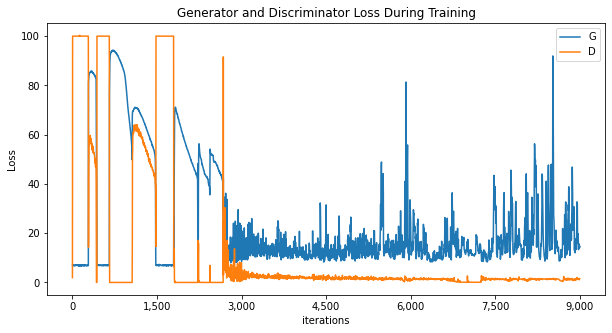

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x*3), ',')))
plt.show()

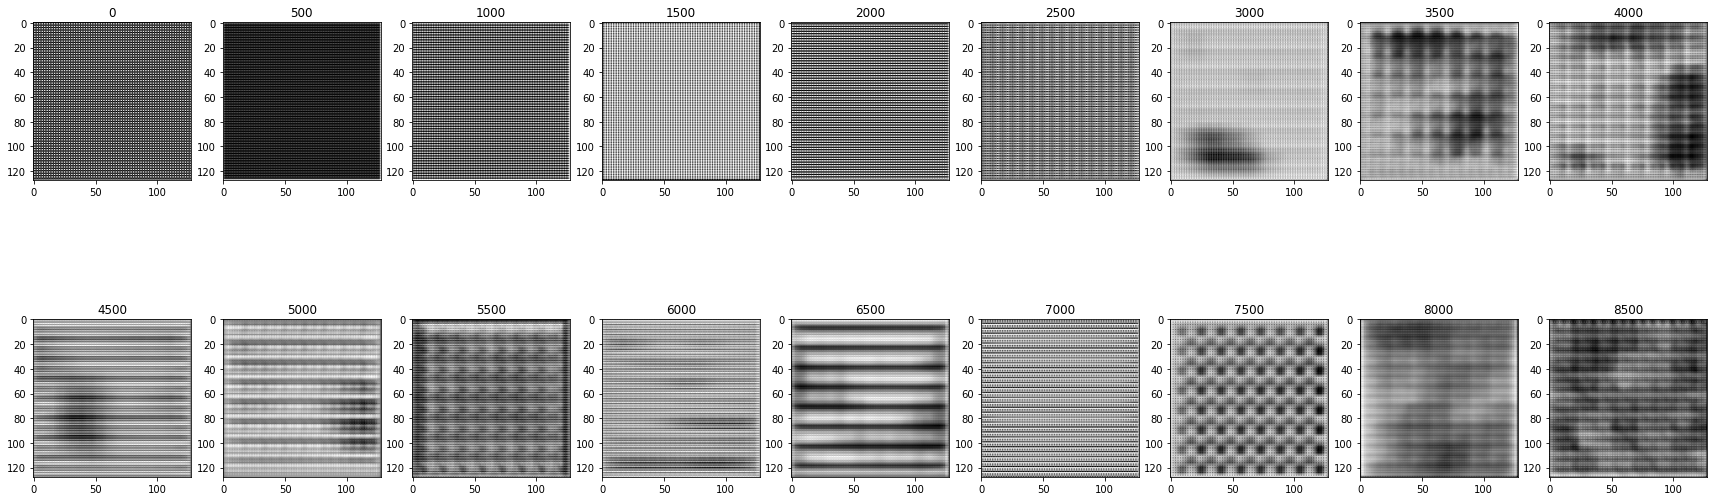

In [ ]:
plt.figure(figsize=(30,10))
for i in range(len(img_list)):
  plt.subplot(2,len(img_list)/2,i+1)
  plt.imshow(img_list[i].mean(0).mean(0), cmap='gray')
  plt.title('{}'.format(i*500))
plt.show()

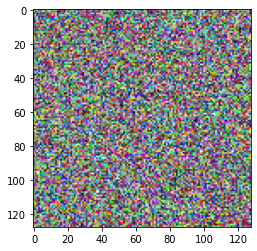

In [ ]:
plt.imshow(np.random.rand(128,128,3))

In [ ]:
torch.save(netG.state_dict(), '/content/drive/MyDrive/netG.pt')

In [ ]:
torch.save(netD.state_dict(), '/content/drive/MyDrive/netD.pt')